In [337]:
from __future__ import absolute_import, division, print_function

import logging
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta, MultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics
# import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

## Vizualizing the heatmaps

In [228]:
import numpy as np
import matplotlib.pyplot as plt

def heat_map(intersection_matrix):
    fig, ax = plt.subplots()

    min_val, max_val = 0, 15

#     intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))

    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

    for i in range(15):
        for j in range(15):
            c = intersection_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')
    


In [229]:
df = pd.read_csv("data/census_block_loc.csv")

In [230]:
df_flat_agg = data
ct_set = set(list(df_flat_agg['CensusTract'].unique()))
df_census_block = pd.read_csv("data/census_block_loc.csv")
df_census_block['CensusTract'] = df_census_block.apply(lambda row : int(row['BlockCode'])//10000, axis=1)
df_census_block = df_census_block[df_census_block['CensusTract'].isin(ct_set)]
df_census_block = df_census_block[['Latitude','Longitude','CensusTract','BlockCode']]
df_census_block.to_csv('points.csv',index=False)

In [231]:
lats = df_census_block['Latitude']
longs = df_census_block['Longitude']

In [232]:
unique_lats = sorted(list(set(lats)))

In [233]:
len(unique_lats)

187

In [234]:
unique_longs = sorted(list(set(longs)))

In [235]:
len(unique_longs)

177

In [236]:
matr = np.zeros((len(unique_lats), len(unique_longs)))

In [237]:
pairs = set([(i,j) for (i,j) in zip(lats,longs)])

In [238]:
len(pairs)

11732

In [239]:
for lat_index, lat in enumerate(unique_lats):
    for long_index, lon in enumerate(unique_longs):
        if (lat, lon) in pairs:
            matr[lat_index][long_index] += 1


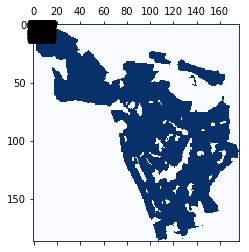

In [240]:
heat_map(matr)

In [ ]:
df_census_block

In [243]:
data = pd.read_csv('data/all_features.csv')
df = pd.read_csv("data/all_features.csv")
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)
data['target'] = data['target'].astype(int)

In [304]:
data['CensusTract'].astype('int32')

0        1645261832
1        1645262032
2        1645263232
3        1645263532
4        1645263632
            ...    
21625    1725291933
21626    1725291934
21627    1725293533
21628    1725293534
21629    1725293932
Name: CensusTract, Length: 21630, dtype: int32

In [305]:
df_census_block['CensusTract'].astype('int32')

755      1725286034
756      1725286034
757      1725286034
758      1725286034
759      1725286034
            ...    
36711    1645292532
36712    1645292532
36713    1645292532
36716    1645295332
36910    1645292532
Name: CensusTract, Length: 11732, dtype: int32

In [306]:
tract_lat_long = pd.DataFrame(df_census_block[['CensusTract', 'Latitude','Longitude']])

In [307]:
tract_lat_long

,CensusTract,Latitude,Longitude
755,36085024402,40.493568,-74.251508
756,36085024402,40.493568,-74.248342
757,36085024402,40.493568,-74.245176
758,36085024402,40.493568,-74.242010
759,36085024402,40.493568,-74.238844
...,...,...,...
36711,36005030900,40.911910,-73.915930
36712,36005030900,40.911910,-73.912764
36713,36005030900,40.911910,-73.909598
36716,36005033700,40.911910,-73.900101


In [308]:
tract_crimes = pd.DataFrame(data[['CensusTract', 'target']])

In [309]:
tract_crimes.groupby(['CensusTract']).sum().to_csv('temp.csv')
tract_crimes = pd.read_csv('temp.csv')

In [316]:
lat_long_crimes = pd.merge(tract_crimes, tract_lat_long)

In [317]:
lat_long_crimes

,CensusTract,target,Latitude,Longitude
0,36005000200,38,40.798844,-73.862111
1,36005000200,38,40.798844,-73.858945
2,36005000200,38,40.801106,-73.862111
3,36005000200,38,40.801106,-73.858945
4,36005000200,38,40.801106,-73.855779
...,...,...,...,...
11727,36085032300,102,40.645075,-74.185025
11728,36085032300,102,40.645075,-74.181859
11729,36085032300,102,40.645075,-74.178693
11730,36085032300,102,40.645075,-74.175528


In [318]:
lats = lat_long_crimes['Latitude']
longs = lat_long_crimes['Longitude']
pairs = set([(i,j) for (i,j) in zip(lats,longs)])


In [319]:
crime_map = np.zeros((len(unique_lats), len(unique_longs)))

In [322]:
for lat_index, lat in enumerate(unique_lats):
    for long_index, lon in enumerate(unique_longs):
        if (lat, lon) in pairs:
            crimes = lat_long_crimes[(lat_long_crimes['Latitude'] == lat) &  (lat_long_crimes['Longitude'] == lon)]['target']
            crime_map[lat_index][long_index] += crimes

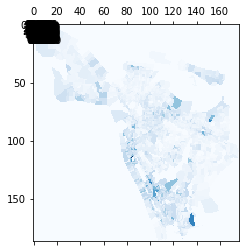

In [324]:
heat_map(crime_map)

### Build Weights Matrix and the cenus to ID Mapping and pickle it for future use

In [342]:
unique_tracts = len(lat_long_crimes['CensusTract'].unique())

In [356]:
unique_tracts_list = lat_long_crimes['CensusTract'].unique()

In [330]:
#BUILD ID -> Tract 

In [341]:
# c_tract_id = {}
# c_id_tract = {}
# i = 0
# for c in lat_long_crimes['CensusTract'].unique():
#     if c not in c_tract_id:
#         c_tract_id[c] = i
#         c_id_tract[i] = c
#         i+=1
# with open("c_tract_id.pkl", 'wb') as f:
#     pickle.dump(c_tract_id, f)
# with open("c_id_tract.pkl", 'wb') as f:
#     pickle.dump(c_id_tract, f)
c_tract_id =  pickle.load(open("c_tract_id.pkl", 'rb'))
c_id_tract = pickle.load(open("c_id_tract.pkl", 'rb'))

In [343]:
W = np.zeros((unique_tracts,unique_tracts))

In [344]:
nbr_matrix = matr

In [347]:
tracts = lat_long_crimes['CensusTract']
lats_t = lat_long_crimes['Latitude']
longs_t = lat_long_crimes['Longitude']

In [351]:
lats_ind_value = {j:i for i,j in enumerate(unique_lats)}

In [352]:
longs_ind_value = {j:i for i,j in enumerate(unique_longs)}

In [357]:
for i, tract_i in enumerate(unique_tracts_list): 
    for j, tract_j in enumerate(unique_tracts_list):
        lat_i, long_i = lats_ind_value[lats_t[i]], longs_ind_value[longs_t[i]]
        lat_j, long_j = lats_ind_value[lats_t[j]], longs_ind_value[longs_t[j]]
        if abs(lat_i - lat_j) <=1 and abs(long_i - long_j) <=1:
            W[i][j] = 1
        

In [358]:
with open("weight_matrix", 'wb') as f:
    pickle.dump(W, f)

## Scratch Pad for ICAR Model

In [127]:
def get_data(data, features, target):

    
    ###pick only the tables required#####
    one_table = data[data[target]==1]
    zero_table = data[data[target]==0]
    one_indices = len(one_table)
    zero_indices = len(zero_table)
    
    if one_indices < zero_indices:
        zero_table = zero_table.sample(one_indices)
    else:
        one_table = one_table.sample(zero_indices)
    
    table = one_table.append(zero_table, ignore_index=True)
    
    df_X = table[features]
    df_y = table[target]
    
    
        

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)
    

        

    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

    censor_ids =  torch.from_numpy(np.array(X_train['CensusIds'])).type(torch.int32)

    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)

    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

    test_censor_ids =  torch.from_numpy(np.array(X_test['CensusIds'])).type(torch.int32)
    
    return X_nuts_train, y_nuts_train, censor_ids, X_nuts_test, y_nuts_test, test_censor_ids


## Construct the sequential census ids for points (has lat, long) and data (all features)

In [128]:
points = pd.read_csv('data/points.csv')

In [129]:
points.head()

,Latitude,Longitude,CensusTract,BlockCode
0,40.493568,-74.251508,36085024402,360850244020002
1,40.493568,-74.248342,36085024402,360850244020002
2,40.493568,-74.245176,36085024402,360850244020002
3,40.493568,-74.242010,36085024402,360850244020002
4,40.493568,-74.238844,36085024402,360850244020002


In [168]:
len(set(list(data['CensusTract'])))

2093

In [131]:
census_ids = {}
i = 0
for ct in data['CensusTract']:
    if ct not in census_ids:
        census_ids[ct] = i
        i += 1

In [132]:
i

2093

In [133]:
data['CensusIds'] = [census_ids[c] for c in data['CensusTract']]
points['CensusIds'] = [census_ids[c] for c in points['CensusTract']]

In [169]:
len(set(list(points['CensusIds'])))

2077

In [135]:
points_grpd = points[['CensusIds', 'Latitude', 'Longitude']].groupby(['CensusIds']).mean()

In [143]:
points_grpd.to_csv('temp.csv')

In [144]:
points_grpd = pd.read_csv('temp.csv')

In [145]:
points_grpd

,CensusIds,Latitude,Longitude
0,0,40.805866,-73.860278
1,1,40.807594,-73.851237
2,2,40.819196,-73.858040
3,3,40.801216,-73.909212
4,4,40.817312,-73.865804
...,...,...,...
2072,2088,40.723467,-73.886382
2073,2089,40.596457,-73.969749
2074,2090,40.728744,-73.874774
2075,2091,40.712915,-73.839950


In [ ]:
len(set(list(points_grpd1['CensusIds'])))

In [147]:
k = set(list(data['CensusIds'])) - set(list(points_grpd['CensusIds']))

In [150]:
# for ct in data['CensusTract']
for kk,v in census_ids.items():
    if v in k:
        print(kk,v)

36005018301 101
36005021301 120
36005036902 227
36005040304 258
36047035500 544
36047045400 629
36047048900 644
36061003002 956
36061015802 1075
36061024900 1159
36081028100 1350
36005016900 1764
36047016400 1795
36061014401 1851
36047061003 1980
36061020701 1996


In [86]:
l = points['CensusIds'].max()+1
dists = np.zeros((l, l))
for i in range(l):
    for j in range(l):
        
        

In [87]:
i

2091

In [16]:
bool_split = 9
offset = 1
def sep_data(row):
    if row['target'] >= bool_split + offset :
        return 1
    elif row['target'] <= bool_split - offset :
        return 0
    else:
        return float('nan')
features = ['TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment','restaurants', 'bar', 'park', 'subway_station', 'CensusIds']
target = 'binary_target'       
data_new = deepcopy(data)
data_new['binary_target'] = data_new.apply(sep_data, axis=1)
data_new = data_new.dropna()
print(len(data_new[data_new['binary_target']==0]), len(data_new[data_new['binary_target']==1]))
X_nuts_train, y_nuts_train, place_mapping, X_nuts_test, y_nuts_test, test_place_mapping= get_data(data_new, features, target)

18709 2143


In [60]:
W = W.type(torch.int32)
place_mapping = place_mapping.type(torch.int32)

In [15]:
torch.sum(W, axis=1)

tensor([2093, 2093, 2093,  ..., 2093, 2093, 2093])

In [75]:
def old_model(data_x, data_y, D, W, place_mapping):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    #unstructured random noise
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    
    #structured random noise
    sd_s = pyro.sample("sd_s",dist.Uniform(0,100))
    sigma2_si = 1/(sd_s**2) 
    s_i = pyro.sample("s_i",dist.Normal(0, sigma2_si))
    m = torch.sum(W, axis=1) + 1
    W_star = W/m
    mean_S_j_given_S_i = 0
    p = len(W)
    mean_S_j_given_S_i =  torch.sum(W[i] * s_i)
    sd_S_j_given_S_i = pyro.sample("sd_sij",dist.Uniform(0,100))
    s_ij = pyro.sample("s_ij",dist.Normal(mean_S_j_given_S_i, sd_S_j_given_S_i))
    
    logit = logit + u_i + s_ij
    
    p = 1. / (1 + torch.exp(-logit)) 


    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    

In [76]:
nuts_kernel = NUTS(model, jit_compile=True, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=2, warmup_steps=10)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train, X_nuts_train.numpy().shape[1], W, place_mapping)

hmc_samples_2 = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


Warmup:   0%|          | 0/12 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/anaconda3/lib/python3.7/site-packages/pyro/poutine/subsample_messenger.py:56: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you

In [24]:
def funcc(phi, W, place_mapping):
    res = []
    for i in range(len(phi)):
        print(i)
        cur_place = place_mapping[i]
        nbrs = [j for j in W[i] if W[i][j]>0]
        s = 0
        for nbr in nbrs:
            s += (phi[nbr] - phi[cur_place])
        res.append(s)
    res = torch.from_numpy(np.array(res)).type(torch.float32)
    return res
        

In [25]:
p = len(W)

In [26]:
p

2093

In [27]:
place_mapping

tensor([1375, 1819,  797,  ...,  318,  561,  870], dtype=torch.int32)

In [ ]:
z = torch.FloatTensor([1,2,3])


In [ ]:
z

In [ ]:
z.shape

In [46]:
z.repeat(z.shape[0],1)

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

In [ ]:
beta = []
for i in range(D+1):
    beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        

In [ ]:
W = z

In [45]:
W = [[1,1,1],[1,1,1],[1,1,1]]
W = torch.from_numpy(np.array(W)).type(torch.int32)

In [46]:
p = len(W)
p

3

In [47]:
W = W/(torch.sum(W, axis=1) + 1)

In [48]:
D = torch.diag(torch.sum(W, axis=1) + 1)


In [49]:
D

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [50]:
3 *torch.abs(D-W)

tensor([[3, 0, 0],
        [0, 3, 0],
        [0, 0, 3]])

In [ ]:
dist.MultivariateNormal(torch.zeros(p), 3 * torch.abs((D - W)))

In [55]:
phi = pyro.sample("phi", dist.MultivariateNormal(torch.zeros(p).type(torch.float32), 3 * torch.abs((D - W).type(torch.float32))))

In [59]:
D = torch.diag(torch.sum(W, axis=1) + 1)


phi = pyro.sample("phi", dist.MultivariateNormal(torch.zeros(p).type(torch.float32), sigma2_si * (D - W).type(torch.float32)))

In [61]:
def new_model(data_x, data_y, D, W, place_mapping):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    #unstructured random noise
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    
    #structured random noise
    p = len(W)
    sd_s = pyro.sample("sd_s",dist.Uniform(0,100))
    sigma2_si = 1/(sd_s**2) 
    
    D = torch.diag(torch.sum(W, axis=1) + 1)
    
    
    phi = pyro.sample("phi"+str(i), dist.Normal(torch.zeros(p), sigma2_si * (D - W)))
    
    print("making people")
    people = phi.repeat(phi.shape[0],1).transpose(0,1) * W
    print("making nbrs")
    nbrs = phi.repeat(phi.shape[0],1) * W
    print("making diff")
    diff = torch.sum((people - nbrs) ** 2, axis=1)
    
    
    

    logit = logit + u_i + diff
    
    p = 1. / (1 + torch.exp(-logit)) 


    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    

In [ ]:
nuts_kernel = NUTS(new_model, jit_compile=True, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=2, warmup_steps=1)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train, X_nuts_train.numpy().shape[1], W, place_mapping)

hmc_samples_3 = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
